## Dataset

*We need to conver text to numerical value*
* We need a vocabulary mapping for each word(or character) to int
* We need to setup a pytorch dataset
* Make sure that each sentence (input) is same size (padding) and dataloader

In [4]:
import os
from collections import defaultdict
import pandas as pd
import spacy
import torch
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from torch.utils.tensorboard import SummaryWriter
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.5 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
zsh:1: command not found: nltk.download


In [5]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:

class Vocabulary():
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold

    
    def __len__(self):
        return len(self.itos)


    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentence_list):
        frequency = {}
        idx = 4
        N = 50

        for sentence in sentence_list:
            for token in self.tokenizer_eng(sentence):

                frequency[token] = 1 + frequency.get(token, 0)

                if frequency[token] == self.freq_threshold:
                    self.stoi[token] = idx
                    self.itos[idx] = token
                    idx += 1
    
    def tokenize(self, text):
        token_sent = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in token_sent
            ]
    def vocabulary_size(self):
        return len(self.stoi)

In [7]:
v = Vocabulary(freq_threshold=1)

v.build_vocabulary(["This is a good place to find a city"])
print(v.stoi)
print(v.tokenize("This is a good place to find a city here!! test"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 6, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 11}
[4, 5, 6, 7, 8, 9, 10, 6, 11, 3, 3, 3, 3]


In [87]:
class FlickrDataset(Dataset):
    max_len = 45
    def __init__(self, root_dir, data_dict, vocabulary: Vocabulary, transform=None, train=True):
        self.root_dir = root_dir
        self.data_dict = data_dict
        self.transform = transform

        # get the image and caption
        self.train = train
        self.caption = []
        self.item = self.setup_item()

        # Create our own vocabulary
        self.vocabulary = vocabulary
        self.sos_token = torch.tensor([self.vocabulary.stoi['<SOS>']], dtype=torch.int64)
        self.eos_token = torch.tensor([self.vocabulary.stoi['<EOS>']], dtype=torch.int64)
        self.pad_token = torch.tensor([self.vocabulary.stoi['<PAD>']], dtype=torch.int64)
    
    def __len__(self):
        return len(self.item)
    
    def setup_item(self):
        item = []
        if self.train:
            for image_id, image_captions in self.data_dict.items():
                for caption in image_captions:
                    self.caption.append(caption)
                    item.append((image_id, caption))
        else:
            for image_id, image_captions in self.data_dict.items():
                self.caption.extend(image_captions)
                item.append((image_id, image_captions))
        return item


    def __getitem__(self, index):
        # get image
        image_path = os.path.join(self.root_dir, self.item[index][0])
        img = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # get caption
        caption = self.item[index][1]
        
        if self.train:
            cap_len = len(self.vocabulary.tokenize(caption))
            num_pad = FlickrDataset.max_len - cap_len - 2
            if num_pad < 0:
                raise ValueError("Caption too long")
            num_caption = torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(caption), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)
            return img, num_caption
        else:
            captions = torch.zeros(5, 45).to(torch.long)
            for idx, cap in enumerate(caption):
                cap_len = len(self.vocabulary.tokenize(cap))
                num_pad = FlickrDataset.max_len - cap_len - 2
                if num_pad < 0:
                    raise ValueError("Caption too long")
                num_caption =    torch.cat([
                        self.sos_token ,
                        torch.tensor(self.vocabulary.tokenize(cap), dtype=torch.int64),
                        self.eos_token,
                        torch.tensor([self.pad_token] * num_pad, dtype=torch.int64)], dim=0)

                captions[idx] = num_caption
            return img, torch.LongTensor(captions)


In [88]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, batch):
        img = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(img, 0)
        target = [item[1] for item in batch]
        target = pad_sequence(target, batch_first=False, padding_value=self.pad_idx)
        return img, target

In [89]:
def get_loader(
    root_folder,
    data_dict,
    transform,
    vocabulary,
    batch_size=32,
    train=True,
    num_workers=1,
    shuffle=True,
    pin_memory=False,
):
    dataset = FlickrDataset(root_folder, data_dict=data_dict, transform=transform, train=train, vocabulary=vocabulary)

    pad_idx = dataset.vocabulary.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        #collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset

In [63]:

def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data

df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [12]:
import random
nlp = spacy.load("en_core_web_sm")
# image_dict: a dictionary mapping image_id -> list of captions
# For tokenization here, we use a simple lower().split(); in practice use a robust tokenizer.
def compute_vocab(image_ids, image_dict):
    vocab = set()
    for img in image_ids:
        for caption in image_dict[img]:
            vocab.update(nlp.tokenizer(caption))
    return vocab

# Step 1: Initial random split at the image level
image_dict = df.groupby("image")["caption"].apply(list).to_dict()
all_images = list(image_dict.keys())
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))  # e.g., 80/20 split
train_images = set(all_images[:split_idx])
val_images = set(all_images[split_idx:])

# Step 2: Compute the vocabulary for each split
train_vocab = compute_vocab(train_images, image_dict)
val_vocab = compute_vocab(val_images, image_dict)

# Step 3: Find words in train that are missing in validation
missing_words = train_vocab - val_vocab

# Step 4: For each missing word, move one training image that contains it to validation
for word in missing_words:
    # Find candidate images in training whose captions contain the word
    candidates = [img for img in train_images 
                  if any(word in nlp.tokenizer(caption) for caption in image_dict[img])]
    if candidates:
        selected = candidates[0]
        train_images.remove(selected)
        val_images.add(selected)
        # Recompute vocabularies after moving an image
        train_vocab = compute_vocab(train_images, image_dict)
        val_vocab = compute_vocab(val_images, image_dict)

print("Final training set size:", len(train_images))
print("Final validation set size:", len(val_images))


KeyboardInterrupt: 

In [119]:
import random

# image_dict: mapping image_id -> list of captions
# A simple tokenizer using lower() and split(), adjust as needed.
nlp = spacy.load("en_core_web_sm")
def tokenize(caption):
    return nlp.tokenizer(caption)

def compute_vocab(image_ids, image_dict):
    vocab = set()
    for img in image_ids:
        for caption in image_dict[img]:
            vocab.update(tokenize(caption))
    return vocab

# Step 1: Initial random split (at image level)
all_images = list(image_dict.keys())
random.shuffle(all_images)
initial_split = int(0.8 * len(all_images))
train_images = set(all_images[:initial_split])
val_images = set(all_images[initial_split:])

# Step 2: Compute training vocabulary
train_vocab = compute_vocab(train_images, image_dict)

# Step 3: Adjust validation: move any image that introduces a new word into training.
adjusted_val = set()
for img in val_images:
    captions = image_dict[img]
    # If every word in all captions is already in train_vocab, keep this image in validation.
    if all(word in train_vocab for caption in captions for word in tokenize(caption)):
        adjusted_val.add(img)
    else:
        train_images.add(img)

# Update validation set after adjustment.
val_images = adjusted_val

print("Final training set size:", len(train_images))
print("Final validation set size:", len(val_images))
print("Validation vocab is subset of training vocab:",
      compute_vocab(val_images, image_dict).issubset(compute_vocab(train_images, image_dict)))


NameError: name 'image_dict' is not defined

In [90]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [91]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [92]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()

8508

In [93]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)

In [94]:
import random
random_index = random.randint(0, len(train_dataset) - 1)

# Get the random element
random_image, random_label = train_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
print([vocabulary.itos[token] for token in random_label.tolist()])

Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([45])
['<SOS>', 'a', 'person', 'in', 'a', 'field', 'looks', 'through', 'a', 'telescope', 'while', 'a', 'blue', 'car', 'approaches', 'or', 'waits', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [95]:
folder

'data/images/'

In [96]:
32360

32360

In [97]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
for image, caption in train_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    first_image = image[index]
    print(first_image.shape)
    first_caption = caption[index]
    print(first_caption.shape)
    break

torch.Size([32, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([45])


In [98]:
val_dataset = FlickrDataset(root_dir=folder, data_dict=val_data,vocabulary=vocabulary,
                        transform=transform, train=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7338688..1.9325962].


Random Shape: torch.Size([3, 224, 224])
Random Caption: torch.Size([5, 45])


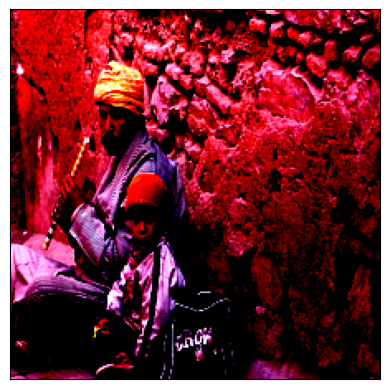

['<SOS>', 'a', 'man', 'and', 'a', 'boy', 'sitting', 'with', 'their', 'back', 'to', 'a', 'stone', 'wall', ',', 'the', 'man', 'paying', 'a', 'flute', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'man', 'and', 'a', 'small', 'boy', 'sit', 'and', 'rest', 'against', 'a', 'stone', 'wall', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'a', 'man', 'holding', 'a', 'flute', 'and', 'a', 'boy', 'sit', 'on', 'a', 'street', 'against', 'a', 'red', 'wall', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PA

In [99]:
random_index = random.randint(0, len(val_dataset) - 1)

# Get the random element
random_image, random_label = val_dataset[random_index]

print("Random Shape:", random_image.shape)
print("Random Caption:", random_label.shape)
plt.xticks([])
plt.yticks([])
plt.imshow(random_image.permute(1, 2,0))
plt.show()
print([vocabulary.itos[token] for token in random_label[0].tolist()])
print([vocabulary.itos[token] for token in random_label[1].tolist()])
print([vocabulary.itos[token] for token in random_label[2].tolist()])
print([vocabulary.itos[token] for token in random_label[3].tolist()])
print([vocabulary.itos[token] for token in random_label[4].tolist()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9468161].


torch.Size([32, 5, 45])
torch.Size([32, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([5, 45])


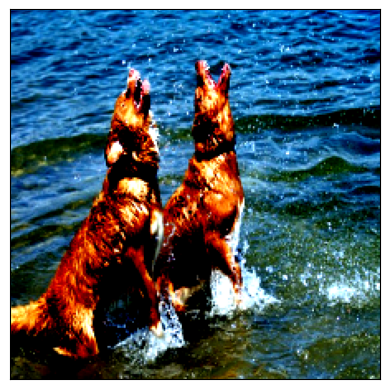

['<SOS>', 'two', 'brown', 'dog', 'play', 'together', 'in', 'the', 'water', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'two', 'brown', 'dogs', 'playing', 'in', 'water', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'two', 'dogs', 'playing', 'in', 'the', 'ocean', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD

In [100]:
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
for image, caption in val_loader:
    print(caption.shape)
    print(image.shape)
    index = random.randint(0, 31)
    random_image = image[index]
    print(random_image.shape)
    random_label = caption[index]
    print(random_label.shape)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(random_image.permute(1, 2,0))
    plt.show()
    print([vocabulary.itos[token] for token in random_label[0].tolist()])
    print([vocabulary.itos[token] for token in random_label[1].tolist()])
    print([vocabulary.itos[token] for token in random_label[2].tolist()])
    print([vocabulary.itos[token] for token in random_label[3].tolist()])
    print([vocabulary.itos[token] for token in random_label[4].tolist()])
    break

In [101]:
def save_data(data_dict, save_path="data/caption_train.csv"):
    data = [(image_name, caption) for image_name, captions in data_dict.items() for caption in captions]
    df = pd.DataFrame(data, columns=["image", "caption"])
    df.to_csv(save_path)

In [102]:
save_data(train_data)
save_data(val_data, 'data/caption_val.csv')

## Pad Sequence

In [18]:
import torch
from torch.nn.utils.rnn import pad_sequence
# Example sequences of different lengths
sequences = [torch.tensor([1, 2, 3]),
             torch.tensor([4, 5]),
             torch.tensor([6, 7, 8, 9])]
padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
padded_sequences

tensor([[1, 2, 3, 0],
        [4, 5, 0, 0],
        [6, 7, 8, 9]])

## Model

In [27]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

## Loading inceptionnet

In [ ]:
model = resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
model.parameters()

<generator object Module.parameters at 0x16aab1f50>

In [30]:
from PIL import Image
from torchvision import transforms
image_path = "data/images/667626_18933d713e.jpg"  # Replace with your image path
image = Image.open(image_path)
transformation = transforms.transforms.Compose([transforms.transforms.Resize((256, 256)),
                                                transforms.transforms.ToTensor()])

image_tensor = transformation(image)
#image_tensor = image_tensor.permute(1, 2, 0)
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)


torch.Size([1, 3, 256, 256])


In [31]:
with torch.no_grad():
    output = model(image_tensor)
output.shape

torch.Size([1, 1000])

## Encoder

In [32]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

In [33]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        ## loading inception model
        resnet = resnet50(weights="ResNet50_Weights.IMAGENET1K_V2")
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def freeze(self, train_CNN):
        for param in self.resnet.parameters():
            param.requires_grad = train_CNN
        

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.shape[0], -1)
        features = self.linear(features)
        return self.dropout(self.relu(features))


## test for Decoder

In [34]:
vocabulary.vocabulary_size()

8508

In [35]:
enocder = EncoderCNN(256)
embed = nn.Embedding(vocabulary.vocabulary_size(), 256)
lstm = nn.LSTM(256, 256, batch_first=True)
for img, caption in train_loader:
    output = enocder(img) # feature
    print(caption.shape)
    output = output.unsqueeze(1)
    caption = embed(caption) #embedding
    print(caption.shape)
    print(output.shape)
    print(torch.cat((output, caption), dim=1).shape)
    output, _ = lstm(output)
    print(output.shape)
    break


torch.Size([32, 45])
torch.Size([32, 45, 256])
torch.Size([32, 1, 256])
torch.Size([32, 46, 256])
torch.Size([32, 1, 256])


## Decoder

In [36]:
print(torch.cat((torch.Tensor([[1,2,3],[7,8,9]]).unsqueeze(0), torch.Tensor([[4,5,6],[9,10,11]]).unsqueeze(0)), dim=-2))

tensor([[[ 1.,  2.,  3.],
         [ 7.,  8.,  9.],
         [ 4.,  5.,  6.],
         [ 9., 10., 11.]]])


In [37]:
class DecoderRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        # teacher forcing
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        
        hidden, _ = self.lstm(embeddings)
        return self.linear(hidden)


In [38]:
enocder = EncoderCNN(256)
decoder = DecoderRNN(256, 256, len(vocabulary), num_layers=1)
for img, caption in train_loader:
    features = enocder(img)
    print(features.shape)
    print(caption.shape)
    out = decoder(features, caption[:,:-1])
    print(out.shape)
    break
    

torch.Size([32, 256])
torch.Size([32, 45])
torch.Size([32, 45, 8508])


## CNNtoRNN

In [39]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoder = EncoderCNN(embed_size=embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
    
    def forward(self, img, captions):
        features = self.encoder(img)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_img(self, img, vocab, max_length=50):
        result_caption = []

        with torch.no_grad():
            feature = self.encoder(img).unsqueeze(1) # adding dim for seq len feature is of shape (batch_size, 1, embed dim) 
            states = None

            for _ in range(max_length):
                hidden, states = self.decoder.lstm(feature, states) # hidden should be (batch, 1, hidden_state)
                output = self.decoder.linear(hidden.squeeze(1)) #(remove seq_len) when passed hidden would be (batch_size, hidden_state) ->  (batch_size, vocab_size)
                predicted = output.argmax(-1) # highest probablities word predicted is of shape (batch_size) and each element has to be from 0 to vocab length - 1
                result_caption.append(predicted.item())
                feature = self.decoder.embed(predicted).unsqueeze(1) # only taking the most recent word (batch_size, embed_dim) and we unsquence to add seq len dim to it (batch_size, 1, embed_dim)
                if vocab.itos[predicted.item()] == "<EOS>":
                    break
            
            return [vocab.itos[idx] for idx in result_caption] #return the final sentence


In [40]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
print(vocabulary.vocabulary_size())
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

8508


In [41]:
## Santity Check
model = CNNtoRNN(256, 128, vocabulary.vocabulary_size(), 1)
for img, caption in train_loader:
    print(model.caption_img(img[6].unsqueeze(0), vocabulary))
    break


['upon', 'jug', 'raft', 'villages', 'racedog', 'biking', 'protectors', 'inspecting', 'moutainside', 'stroll', 'bumpers', 'floating', 'gazed', 'darkness', 'intertube', 'pigeon', 'christmas', 'unique', 'by', 'bit', 'dramatic', 'necklaces', 'contest', 'entering', 'search', 'steering', 'appears', 'escape', 'hr', 'priests', 'nordic', 'priests', 'anti', 'cheeks', 'assist', 'domino', 'threatening', 'rope', 'restaurants', 'headwraps', 'flyer', 'huge', 'closer', 'formula', 'exposing', 'belt', 'crouching', 'shimp', 'dense', 'fedex']


## Training

In [103]:
import torch.nn as nn
import torch
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


In [104]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [105]:
folder = "data/images/"
df = pd.read_csv("data/captions.txt")
data_dict = {}
caption_dict = defaultdict(list)
for _, row in df.iterrows():
    caption_dict[row.image].append(row.caption)
train_data, val_data = train_val_split(caption_dict)

In [106]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711])
])

In [107]:
vocabulary = Vocabulary(1)
vocabulary.build_vocabulary(pd.read_csv("data/captions.txt").caption.to_list())
vocabulary.vocabulary_size()


8508

In [108]:
device = "cpu"
if torch.cuda.is_available():
    devcie = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

print(device)

mps


In [109]:
train_CNN = False
embed_size = 256
hidden_size = 256
vocab_size = vocabulary.vocabulary_size()
num_layers = 1
lr= 3e-4
num_epochs = 100

load_model = False
save_model = False
step = 0

In [110]:
train_dataset = FlickrDataset(root_dir=folder, data_dict=train_data,vocabulary=vocabulary,
                        transform=transform, train=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

In [111]:
writer = SummaryWriter(log_dir="runs/flickr")
model_path = "state_dict.py"
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocabulary.stoi["<PAD>"])
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=lr)
start_epoch = 0
if load_model:
    state_dict = torch.load(model_path)
    model = state_dict['model']
    optimizer = state_dict['optimizer']
    step = state_dict['steps']
    start_epoch = 1 + state_dict['epochs']

In [116]:
def corpus_meteor(expected, predicted):
    meteor_score_sentences_list = list()
    [meteor_score_sentences_list.append(meteor_score(expect, predict)) for expect, predict in zip(expected, predicted)]
    meteor_score_res = np.mean(meteor_score_sentences_list)
    return meteor_score_res

def validation(model, device, validation_loader, vocabulary, criterion,global_step, writer, epoch):
    model.eval()
    references = []
    hypotheses = []
    epoch_loss = []
    ignore = {vocabulary.stoi['<SOS>'], vocabulary.stoi['<PAD>']}
    with torch.inference_mode():
        batch_iterator = tqdm(enumerate(validation_loader),total=len(validation_loader) ,desc=f"Evaluation Processing Epoch: {epoch:02d}", leave=False)
        for idx, (imgs, captions) in batch_iterator:
            imgs, captions = imgs.to(device), captions.to(device)
            sample_caption = captions[:,0,:].clone() # the shape of our validation dataset is going to be (batch_size, 5, max_cap_len) for the purposes of calculating the validation loss we only take the first caption out of the 4
            outputs = model(imgs, sample_caption[:,:-1])
            loss = criterion(outputs.view(-1, outputs.shape[-1]), sample_caption.view(-1))
            epoch_loss.append(loss.item())
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
            writer.add_scalar("Evaluation loss", loss.item(), global_step=global_step)
            
            # gather all references and hypothesis for blue and meteor score calculations
            # references
            for i in range(captions.shape[0]): #looping over the batch dimension
                caps = []
                for j in range(captions.shape[1]):
                    caps.append([ vocabulary.itos[token] for token in captions[i,j].tolist() if token not in ignore])
                references.append(caps)
            
            # Hypothesis
            predictions = torch.argmax(outputs, dim=-1)
            for prediction in predictions.tolist():
                hypotheses.append([vocabulary.itos[token] for token in prediction if token not in ignore])
        
        bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
        bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
        bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
        bleu_4 = corpus_bleu(references, hypotheses)
        meteor = corpus_meteor(references, hypotheses)
        
        writer.add_scalar('val_bleu1', bleu_1, epoch)
        writer.add_scalar('val_bleu2', bleu_2, epoch)
        writer.add_scalar('val_bleu3', bleu_3, epoch)
        writer.add_scalar('val_bleu4', bleu_4, epoch)
        writer.add_scalar('val_loss', np.mean(epoch_loss), epoch)
        writer.add_scalar('val_meteor', meteor, epoch)
        
        print(f'''Validation Epoch: {epoch}\t
              BLEU-1: {bleu_1}\t
              BLEU-2: {bleu_2}\t
              BLEU-3: {bleu_3}\t
              BLEU-4: {bleu_4}\t
              Meteor: {meteor}'''.format(epoch, bleu_1, bleu_2, bleu_3, bleu_4))
        

In [117]:
model.train()
device = "cpu"
if torch.cuda.is_available():
    devcie = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
    
for epoch in range(start_epoch, num_epochs):
    epoch_loss = 0
    batch_iterator = tqdm(enumerate(train_loader),total=len(train_loader) ,desc=f"Training Processing Epoch: {epoch:02d}", leave=False)
    for idx, (imgs, captions) in batch_iterator:
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, captions[:,:-1])
        loss = criterion(outputs.view(-1, outputs.shape[-1]), captions.view(-1))
        epoch_loss += loss.item()
        batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})
        writer.add_scalar("Training loss", loss.item(), global_step=step)
        step += 1
        loss.backward()
        optimizer.step()
        break
        
    writer.add_scalar("Training loss", epoch_loss/len(train_loader), global_step=epoch)
    validation(model, device, val_loader, vocabulary, criterion, step, writer, epoch)
    
        
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
            "epoch": start_epoch
        }
        torch.save(checkpoint, model_path)
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.10f}')



/Users/ngkuissi/miniforge3/envs/image_cap/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ngkuissi/miniforge3/envs/image_cap/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/ngkuissi/miniforge3/envs/image_cap/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower orde

Validation Epoch: 0	
              BLEU-1: 0.003643921025285764	
              BLEU-2: 9.004439691523386e-156	
              BLEU-3: 1.3949706820688548e-204	
              BLEU-4: 4.476108060370769e-232	
              Meteor: 0.021401683060970546
Epoch [1/100], Loss: 0.0178596323


KeyboardInterrupt: 

In [29]:
device = "cpu"
if torch.cuda.is_available():
    devcie = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
    
loader, dataset = get_loader(
    "data/images/", "data/captions.txt", transform
)

embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocabulary)
num_layers = 1

model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [26]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [63]:
image_path = 'data/images/263522013_d118d46b2d.jpg'  # Replace with your image path
image = Image.open(image_path)

In [64]:
image = transform(image)

In [65]:
model = model.to(device)
image = image.to(device)

In [66]:
model.caption_img(image.unsqueeze(0), dataset.vocabulary)

['<SOS>',
 'a',
 'young',
 'boy',
 'in',
 'a',
 'red',
 'shirt',
 'is',
 'jumping',
 'into',
 'a',
 'pool',
 '.',
 '<EOS>']

In [67]:
torch.save(model.state_dict(), 'model.pth')

### Play with packed sequences as they may be useful

In [264]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Suppose we have a batch of padded sequences (batch_first=True)
sequences = torch.tensor([[1, 2, 3, 0, 0],
                          [4, 5, 0, 0, 0],
                          [6, 7, 8, 9, 0]])
# Actual lengths of each sequence before padding
lengths = torch.tensor([3, 2, 4])

# Pack the padded sequence; set batch_first=True if your tensor is (batch, seq_len, ...)
packed = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)

# Now you can pass 'packed' to an RNN


In [268]:
packed

PackedSequence(data=tensor([6, 1, 4, 7, 2, 5, 8, 3, 9]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([2, 0, 1]), unsorted_indices=tensor([1, 2, 0]))

In [269]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Example padded sequences (batch_first=True)
sequences = torch.tensor([[1, 2, 3, 0, 0],  # Length 3
                          [4, 5, 0, 0, 0],  # Length 2
                          [6, 7, 8, 9, 0]]) # Length 4

# Sequence lengths before padding
lengths = torch.tensor([3, 2, 4])

# Convert to PackedSequence
packed = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)

# Simulate passing through an RNN (for example purposes, just return packed)
output_packed = packed

# Convert back to padded tensor
output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)

print(output_padded)
print(output_lengths)

tensor([[1, 2, 3, 0],
        [4, 5, 0, 0],
        [6, 7, 8, 9]])
tensor([3, 2, 4])


In [282]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Example padded sequences (batch_first=True)
sequences = torch.tensor([[1, 2, 3, 0, 0],  # Length 3
                          [4, 5, 0, 0, 0],  # Length 2
                          [6, 7, 8, 9, 0]]) # Length 4
# Actual lengths of each sequence before padding
lengths = torch.tensor([3, 2, 4])

# Pack the sequences
packed = pack_padded_sequence(sequences, lengths, batch_first=True, enforce_sorted=False)

# Define an LSTMCell:
input_size = 1      # Our inputs are scalar integers
hidden_size = 2     # Hidden state size
lstm_cell = torch.nn.LSTMCell(input_size, hidden_size)

batch_size = sequences.size(0)
# Initialize hidden and cell states for the entire batch
h_t = torch.zeros(batch_size, hidden_size)
c_t = torch.zeros(batch_size, hidden_size)

# We'll iterate over time steps using packed.batch_sizes:
data = packed.data             # Flattened data (sum(lengths) elements)
batch_sizes = packed.batch_sizes  # Tensor of shape (T,) giving batch size at each time step

outputs = []
index = 0
for b in batch_sizes:
    # 'b' is the batch size at this time step.
    # Slice the corresponding inputs:
    current_input = data[index:index + b]
    index += b
    # Reshape to (b, input_size)
    current_input = current_input.float().unsqueeze(1)
    print("Current input shape is", current_input.shape)
    print("Current input looks like", current_input)
    # Process with LSTMCell using the first 'b' hidden states
    h_new, c_new = lstm_cell(current_input, (h_t[:b], c_t[:b]))
    # Update the first b elements of our hidden and cell states:
    h_t[:b] = h_new
    c_t[:b] = c_new
    outputs.append(h_new)

# Concatenate the outputs from each time step
outputs_cat = torch.cat(outputs, dim=0)

# Create a new PackedSequence from the outputs
packed_output = torch.nn.utils.rnn.PackedSequence(outputs_cat, batch_sizes)

# Convert back to padded tensor
padded_output, output_lengths = pad_packed_sequence(packed_output, batch_first=True)

print("Padded Output:\n", padded_output)
print("Sequence Lengths:\n", output_lengths)


Current input shape is torch.Size([3, 1])
Current input looks like tensor([[6.],
        [1.],
        [4.]])
Current input shape is torch.Size([3, 1])
Current input looks like tensor([[7.],
        [2.],
        [5.]])
Current input shape is torch.Size([2, 1])
Current input looks like tensor([[8.],
        [3.]])
Current input shape is torch.Size([1, 1])
Current input looks like tensor([[9.]])
Padded Output:
 tensor([[[0.1525, 0.0014],
         [0.1452, 0.0011],
         [0.1388, 0.0007],
         [0.1327, 0.0004]],

        [[0.1183, 0.1988],
         [0.1957, 0.1827],
         [0.1987, 0.1295],
         [0.0000, 0.0000]],

        [[0.1569, 0.0141],
         [0.1605, 0.0115],
         [0.0000, 0.0000],
         [0.0000, 0.0000]]], grad_fn=<TransposeBackward0>)
Sequence Lengths:
 tensor([4, 3, 2])


In [277]:
packed.batch_sizes

tensor([3, 3, 2, 1])

In [280]:
current_input.shape

torch.Size([1, 1])

In [278]:
packed.data 

tensor([6, 1, 4, 7, 2, 5, 8, 3, 9])